<a href="https://colab.research.google.com/github/xvh422/L4-Project/blob/main/J_Carter_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install & Import

In [1]:
!pip install eagleSqlTools
!pip install colossus

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.7/197.7 KB 7.2 MB/s eta 0:00:00


In [2]:
import eagleSqlTools as sql
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as col
from mpl_toolkits.axes_grid1 import make_axes_locatable
import math

from colossus.cosmology import cosmology
from colossus.lss import mass_function

con = sql.connect("vwg533", password = "FZtn087h")

In [3]:
plt.rcParams['font.size'] = '19'

# ab

In [ ]:
# snipshot query
sim_name = 'RefL0100N1504' # 'Snipshots..RefL0100N1504'
# merger tree query
myQuery = "SELECT \
                  PROG.GalaxyID as galaxyid, \
                  PROG.TopLeafID as topleafid, \
                  DES.GalaxyID as descid, \
                  PROG.Redshift as z, \
                  PROG.MassType_DM, \
                  PROG.MassType_Star as Mstar, \
                  PROG.Snapnum as snapnum, \
                  AP.Mass_Star as sm, \
                  PROG.Starformationrate as SFR, \
                  AP.SFR / (AP.Mass_Star+1e-10) as ssfr \
          FROM \
                  %s_Subhalo as PROG, \
                  %s_Subhalo as DES, \
                  %s_Aperture as AP \
          WHERE \
                  DES.MassType_Star > 1.0e9 \
                  and DES.MassType_DM between 0.8e12 and 1.2e12 \
                  and DES.RandomNumber < 0.1 \
                  and DES.SnapNum = 28 \
                  and PROG.GalaxyID between DES.GalaxyID and DES.TopLeafID \
                  and AP.ApertureSize = 30 \
                  and AP.GalaxyID = PROG.GalaxyID \
                  and AP.Mass_Star > 1.0e7 \
          ORDER BY \
                  PROG.Redshift asc"%(sim_name, sim_name, sim_name)
merger_data = sql.execute_query(con, myQuery)


In [ ]:
mask        = (merger_data['snapnum'] == 28)
galaxyIDs   = merger_data['galaxyid'][mask]
topleafIDs  = merger_data['topleafid'][mask]

Results = {}
for galaxyid, topleafid in zip(galaxyIDs, topleafIDs):
  Results[galaxyid] = {}
  mask  = (merger_data['galaxyid'] >= galaxyid) &  (merger_data['galaxyid'] <= topleafid)
  Results[galaxyid]['Mass'] = merger_data['MassType_DM'][mask]
  Results[galaxyid]['z']    = merger_data['z'][mask]


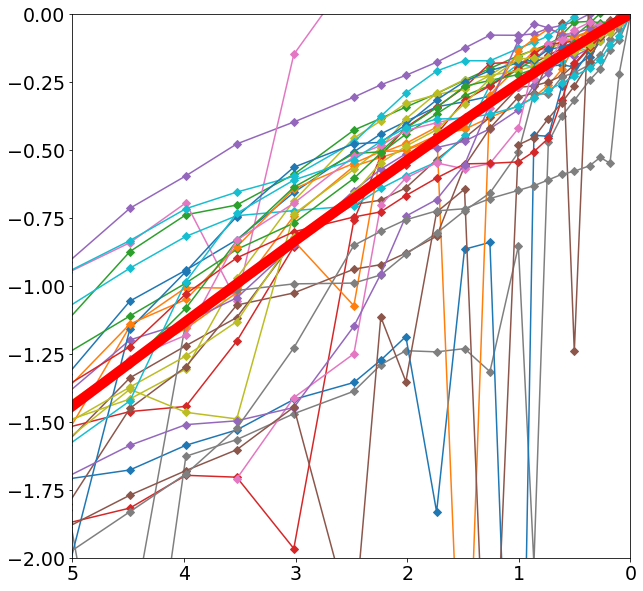

In [ ]:
fig, ax = plt.subplots(1, figsize = (10,10))


for i, galaxyid in enumerate(galaxyIDs):
  z     = Results[galaxyid]['z']
  mass  = Results[galaxyid]['Mass']
  if i < 30:
    ax.plot(z, np.log10(mass/mass[0]), 'D-')


ax.set_xlim(5, 0)
ax.set_ylim(-2, 0)

zs = np.arange(10, 0, -0.01)
a = 0.24
b = 0.75
ax.plot(zs, np.log10((1+zs)**a*np.exp(-b*zs)), '-', linewidth=10, color='red')


fig.show()

# Plot 1 Queries

In [38]:
sim_name = 'RefL0100N1504'
sim_size = 100.
    
# Construct and execute query for each simulation. This query returns the number of galaxies 
# for a given 30 pkpc aperture stellar mass bin (centered with 0.2 dex width). 
Query_1 = "SELECT \
            (MAG.u_nodust - MAG.r_nodust) as u_minus_r, \
            MAG.k_nodust as k, \
            log10(AP.Mass_Star) as mass, \
            (AP.SFR/AP.Mass_Star) as ssfr \
           FROM \
            %s_SubHalo as SH, \
            %s_Magnitudes as MAG, \
            %s_Aperture as AP \
           WHERE \
            SH.SnapNum = 28 and \
            SH.SubGroupNumber = 0 and \
            AP.Mass_Star > 1.0e9 and \
            AP.ApertureSize = 30 and \
            SH.GalaxyID = MAG.GalaxyID and \
            SH.GalaxyID = AP.GalaxyID"%(sim_name, sim_name, sim_name)

Query_2 = "SELECT \
            (MAG.u_nodust - MAG.r_nodust) as u_minus_r, \
            log10(AP.Mass_Star) as mass, \
            (AP.SFR/AP.Mass_Star) as ssfr, \
            (AP.Mass_BH/AP.Mass_Star) as ratio \
           FROM \
            %s_SubHalo as SH, \
            %s_Magnitudes as MAG, \
            %s_Aperture as AP \
           WHERE \
            SH.SnapNum = 28 and \
            SH.SubGroupNumber = 0 and \
            AP.Mass_Star < 3.1622776601684e10 and \
            AP.Mass_Star > 1.0e10 and \
            AP.ApertureSize = 30 and \
            SH.GalaxyID = MAG.GalaxyID and \
            SH.GalaxyID = AP.GalaxyID"%(sim_name, sim_name, sim_name)

Query_blue = "SELECT \
            (MAG.u_nodust - MAG.r_nodust) as u_minus_r, \
            MAG.k_nodust as k, \
            log10(AP.Mass_Star) as mass, \
            (AP.SFR/AP.Mass_Star) as ssfr \
           FROM \
            %s_SubHalo as SH, \
            %s_Magnitudes as MAG, \
            %s_Aperture as AP \
           WHERE \
            SH.SnapNum = 28 and \
            SH.SubGroupNumber = 0 and \
            AP.Mass_Star > 1.0e9 and \
            (AP.SFR/AP.Mass_Star) > 5.0e-12 and \
            AP.ApertureSize = 30 and \
            SH.GalaxyID = MAG.GalaxyID and \
            SH.GalaxyID = AP.GalaxyID"%(sim_name, sim_name, sim_name)

Query_red = "SELECT \
            (MAG.u_nodust - MAG.r_nodust) as u_minus_r, \
            MAG.k_nodust as k, \
            log10(AP.Mass_Star) as mass, \
            (AP.SFR/AP.Mass_Star) as ssfr \
           FROM \
            %s_SubHalo as SH, \
            %s_Magnitudes as MAG, \
            %s_Aperture as AP \
           WHERE \
            SH.SnapNum = 28 and \
            SH.SubGroupNumber = 0 and \
            AP.Mass_Star > 1.0e9 and \
            (AP.SFR/AP.Mass_Star) < 5.0e-12 and \
            AP.ApertureSize = 30 and \
            SH.GalaxyID = MAG.GalaxyID and \
            SH.GalaxyID = AP.GalaxyID"%(sim_name, sim_name, sim_name)

# Execute queries.
Data_1 = sql.execute_query(con, Query_1)
Data_2 = sql.execute_query(con, Query_2)
Data_blue = sql.execute_query(con, Query_blue)
Data_red = sql.execute_query(con, Query_red)

In [5]:
# Replaces zeroes with the smallest nonzero value.
def log_with_zeros(data):
  logs = np.empty(len(data))
  for i in range(0, len(data)):
    if data[i] == 0.0:
      logs[i] = 99.
    else:
      logs[i] = np.log10(data[i])
  m = logs.min()
  for j in range(0, len(logs)):
    if logs[j] == 99.:
      logs[j] = m
    else:
      logs[j] = logs[j]
  return logs

In [6]:
# Splits data into 2 separate arrays for red & blue sequences
def redblue_split(d, ssfr, split):
  red = []
  blue = []
  for i in range(len(d)):
    if ssfr[i] < split:
      red = red + [d[i]]
    else:
      blue = blue + [d[i]]
  red_a = np.array(red)
  blue_a = np.array(blue)
  return red_a, blue_a

In [7]:
# Returns median y values within bins of size 'step' to make a line of "best fit"
def medians(xs, ys, min, max, step):
  xvals = np.arange(min, max+step, step)
  meds = np.empty(len(xvals))
  for i in range(len(meds)):
    yvals = ys[np.logical_and(xs > xvals[i], xs < (xvals[i]+step))]
    meds[i] = np.median(yvals)
  return xvals + step/2, meds

In [26]:
rmeds = medians(Data_red['k'], Data_red['u_minus_r'], -23, -18, 0.2)
bmeds = medians(Data_blue['k'], Data_blue['u_minus_r'], -23, -18, 0.2)

# Plot 1

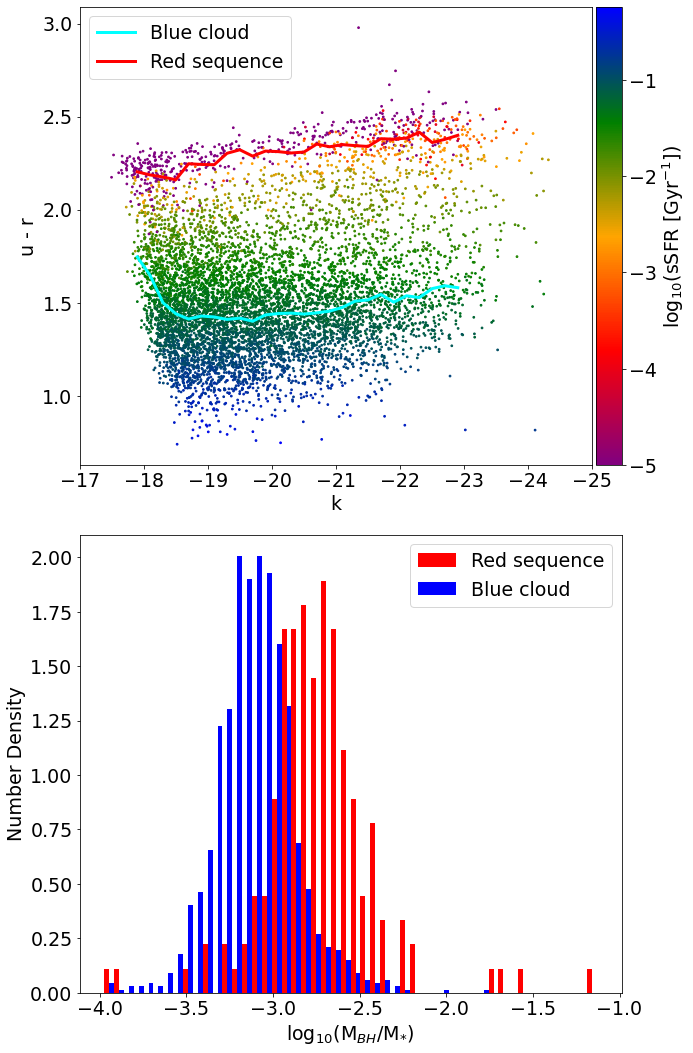

In [48]:
#cmap = plt.cm.gist_stern_r
#'''
cvals = [-2., -1, 0, 1, 2]
colors = ["purple","red","orange","green","blue"]
norm = plt.Normalize(min(cvals),max(cvals))
tuples = list(zip(map(norm,cvals), colors))
cmap = col.LinearSegmentedColormap.from_list("", tuples)
#'''

sSFR = Data_1['ssfr']*10**9
LsSFR = log_with_zeros(sSFR)
LRatio = log_with_zeros(Data_2['ratio'])
RB = redblue_split(LRatio, Data_2['ssfr'], 5.0e-12)
LRatio_r = RB[0]
LRatio_b = RB[1]
Lratios = np.array([LRatio_r, LRatio_b], dtype = object)
Labels = ['Red sequence', 'Blue cloud']

fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (10,15))
im1 = ax1.scatter(Data_1['k'], Data_1['u_minus_r'], s=3, c = LsSFR, cmap = cmap)
im2 = ax2.hist(Lratios, bins = 50, density = True, rwidth = 1.0, color = ['r','b'], label = Labels)

ax1.plot(bmeds[0], bmeds[1], linewidth = 3, color = 'cyan', label = 'Blue cloud')
ax1.plot(rmeds[0], rmeds[1], linewidth = 3, color = 'red', label = 'Red sequence')

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical', label = r'log$_{10}$(sSFR [Gyr$^{-1}$])')

ax1.set_xlabel(r'k')
ax1.set_ylabel(r'u - r')
ax2.set_xlabel(r'log$_{10}$(M$_{BH}$/M$_{*}$)')
ax2.set_ylabel(r'Number Density')
ax1.legend()
ax2.legend()
ax1.set_xlim(-17,-25)

plt.tight_layout()
plt.savefig('Plot_1.jpeg', bbox_inches = 'tight')
plt.show()

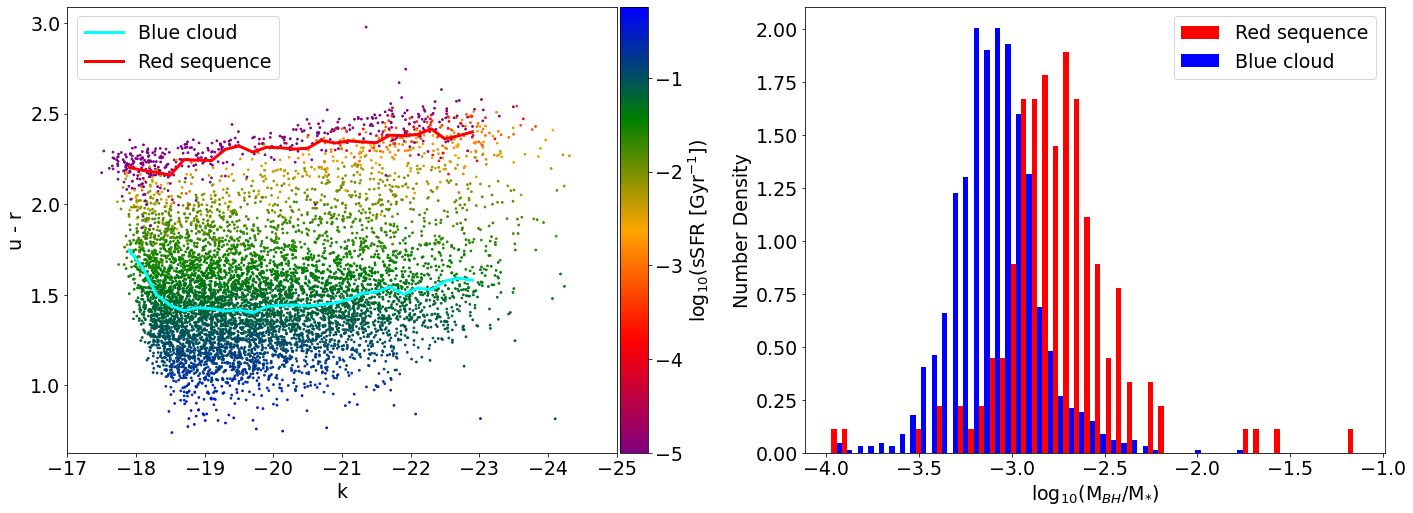

In [49]:
#cmap = plt.cm.gist_stern_r
#'''
cvals = [-2., -1, 0, 1, 2]
colors = ["purple","red","orange","green","blue"]
norm = plt.Normalize(min(cvals),max(cvals))
tuples = list(zip(map(norm,cvals), colors))
cmap = col.LinearSegmentedColormap.from_list("", tuples)
#'''

sSFR = Data_1['ssfr']*10**9
LsSFR = log_with_zeros(sSFR)
LRatio = log_with_zeros(Data_2['ratio'])
RB = redblue_split(LRatio, Data_2['ssfr'], 5.0e-12)
LRatio_r = RB[0]
LRatio_b = RB[1]
Lratios = np.array([LRatio_r, LRatio_b], dtype = object)
Labels = ['Red sequence', 'Blue cloud']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,7.5))
im1 = ax1.scatter(Data_1['k'], Data_1['u_minus_r'], s=3, c = LsSFR, cmap = cmap)
im2 = ax2.hist(Lratios, bins = 50, density = True, rwidth = 1.0, color = ['r','b'], label = Labels)

ax1.plot(bmeds[0], bmeds[1], linewidth = 3, color = 'cyan', label = 'Blue cloud')
ax1.plot(rmeds[0], rmeds[1], linewidth = 3, color = 'red', label = 'Red sequence')

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical', label = r'log$_{10}$(sSFR [Gyr$^{-1}$])')

ax1.set_xlabel(r'k')
ax1.set_ylabel(r'u - r')
ax2.set_xlabel(r'log$_{10}$(M$_{BH}$/M$_{*}$)')
ax2.set_ylabel(r'Number Density')
ax1.legend()
ax2.legend()
ax1.set_xlim(-17,-25)

plt.tight_layout()
plt.savefig('Plot_1L.jpeg', bbox_inches = 'tight')
plt.show()

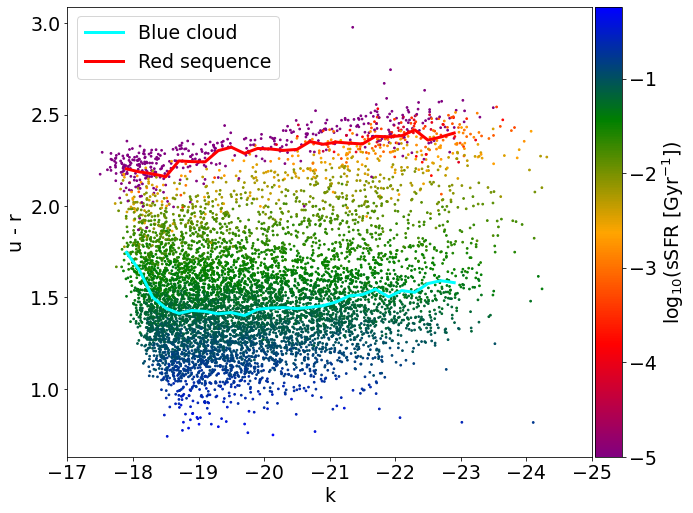

In [50]:
#cmap = plt.cm.gist_stern_r
#'''
cvals = [-2., -1, 0, 1, 2]
colors = ["purple","red","orange","green","blue"]
norm = plt.Normalize(min(cvals),max(cvals))
tuples = list(zip(map(norm,cvals), colors))
cmap = col.LinearSegmentedColormap.from_list("", tuples)
#'''

sSFR = Data_1['ssfr']*10**9
LsSFR = log_with_zeros(sSFR)

fig, (ax1) = plt.subplots(1, 1, figsize = (10,7.5))
im1 = ax1.scatter(Data_1['k'], Data_1['u_minus_r'], s=3, c = LsSFR, cmap = cmap)

ax1.plot(bmeds[0], bmeds[1], linewidth = 3, color = 'cyan', label = 'Blue cloud')
ax1.plot(rmeds[0], rmeds[1], linewidth = 3, color = 'red', label = 'Red sequence')

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical', label = r'log$_{10}$(sSFR [Gyr$^{-1}$])')

ax1.set_xlabel(r'k')
ax1.set_ylabel(r'u - r')
ax1.legend()
ax1.set_xlim(-17,-25)

plt.tight_layout()
plt.savefig('Plot_1_2.jpeg', bbox_inches = 'tight')
plt.show()

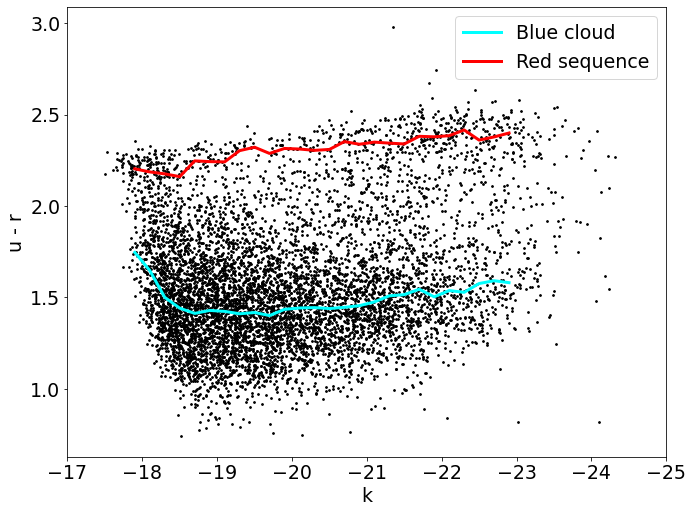

In [51]:
sSFR = Data_1['ssfr']*10**9
LsSFR = log_with_zeros(sSFR)

fig, (ax1) = plt.subplots(1, 1, figsize = (10,7.5))
im1 = ax1.scatter(Data_1['k'], Data_1['u_minus_r'], s=3, c='black')

ax1.plot(bmeds[0], bmeds[1], linewidth = 3, color = 'cyan', label = 'Blue cloud')
ax1.plot(rmeds[0], rmeds[1], linewidth = 3, color = 'red', label = 'Red sequence')

ax1.set_xlabel(r'k')
ax1.set_ylabel(r'u - r')
ax1.legend()
ax1.set_xlim(-17,-25)

plt.tight_layout()
plt.savefig('Plot_1_3.jpeg', bbox_inches = 'tight')
plt.show()

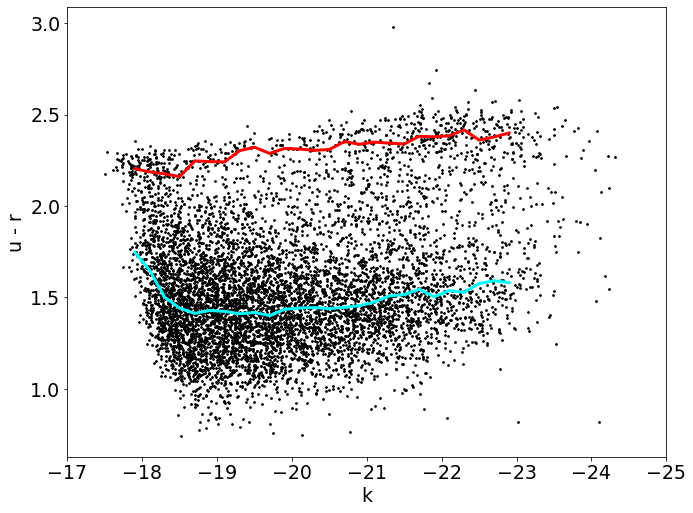

In [53]:
sSFR = Data_1['ssfr']*10**9
LsSFR = log_with_zeros(sSFR)

fig, (ax1) = plt.subplots(1, 1, figsize = (10,7.5))
im1 = ax1.scatter(Data_1['k'], Data_1['u_minus_r'], s=3, c='black')

ax1.plot(bmeds[0], bmeds[1], linewidth = 3, color = 'cyan', label = 'Blue cloud')
ax1.plot(rmeds[0], rmeds[1], linewidth = 3, color = 'red', label = 'Red sequence')

ax1.set_xlabel(r'k')
ax1.set_ylabel(r'u - r')
ax1.set_xlim(-17,-25)

plt.tight_layout()
plt.savefig('Plot_1_4.jpeg', bbox_inches = 'tight')
plt.show()

# Plot 2 Queries

In [ ]:
sim_name = 'RefL0100N1504'
sim_size = 100.

Query_IDs = "SELECT \
            (MAG.u_nodust - MAG.r_nodust) as u_minus_r, \
            log10(AP.Mass_Star) as mass, \
            log10(SH.MassType_DM) as halo, \
            (AP.SFR/AP.Mass_Star) as ssfr, \
            SH.GalaxyID as id \
           FROM \
            %s_SubHalo as SH, \
            %s_Magnitudes as MAG, \
            %s_Aperture as AP \
           WHERE \
            SH.SnapNum = 28 and \
            SH.SubGroupNumber = 0 and \
            SH.MassType_DM > 1.0e12 and \
            (AP.SFR/AP.Mass_Star) < 5.0e-12 and \
            AP.ApertureSize = 30 and \
            SH.GalaxyID = MAG.GalaxyID and \
            SH.GalaxyID = AP.GalaxyID"%(sim_name, sim_name, sim_name)

Data_IDs = sql.execute_query(con, Query_IDs)

In [ ]:
for i in range(len(Data_IDs['id'])):
  print('ID:' ,Data_IDs['id'][i])
  print('u-r:' ,Data_IDs['u_minus_r'][i])
  print('Stellar Mass:' ,Data_IDs['mass'][i])
  print('Halo Mass:' ,Data_IDs['halo'][i])
  print('sSFR:' ,Data_IDs['ssfr'][i])
  print('')

In [ ]:
sim_name = 'RefL0100N1504'
sim_size = 100.
galaxy_id_1 = 16852685 # Red
galaxy_id_2 = 16956975 # Blue

# Red
Query_1 = "SELECT \
            gal.Redshift as z, \
            gal.MassType_Star as mass, \
            gal.MassType_DM as halo, \
            gal.MassType_BH as bh, \
            gal.StarFormationRate as sfr \
          FROM \
            %s_Subhalo as gal, \
            %s_Subhalo as ref \
          WHERE \
            ref.GalaxyID=%s and \
            ((gal.SnapNum > ref.SnapNum and ref.GalaxyID \
            between gal.GalaxyID and gal.TopLeafID) or \
            (gal.SnapNum <= ref.SnapNum and gal.GalaxyID \
            between ref.GalaxyID and ref.TopLeafID)) \
          ORDER BY \
            gal.Redshift"%(sim_name, sim_name, galaxy_id_1)

# Blue
Query_2 = "SELECT \
            gal.Redshift as z, \
            gal.MassType_Star as mass, \
            gal.MassType_DM as halo, \
            gal.MassType_BH as bh, \
            gal.StarFormationRate as sfr \
          FROM \
            %s_Subhalo as gal, \
            %s_Subhalo as ref \
          WHERE \
            ref.GalaxyID=%s and \
            ((gal.SnapNum > ref.SnapNum and ref.GalaxyID \
            between gal.GalaxyID and gal.TopLeafID) or \
            (gal.SnapNum <= ref.SnapNum and gal.GalaxyID \
            between ref.GalaxyID and ref.TopLeafID)) \
          ORDER BY \
            gal.Redshift"%(sim_name, sim_name, galaxy_id_2)

Data_1 = sql.execute_query(con, Query_1)
Data_2 = sql.execute_query(con, Query_2)
r = len(Data_1['z'])
b = len(Data_2['z'])

In [ ]:
def log_with_zeros(data): # Replaces zeroes with the smallest nonzero value.
  logs = np.empty(len(data))
  for i in range(0, len(data)):
    if data[i] == 0.0:
      logs[i] = 99.
    else:
      logs[i] = np.log10(data[i])
  m = logs.min()
  for j in range(0, len(logs)):
    if logs[j] == 99.:
      logs[j] = m
    else:
      logs[j] = logs[j]
  return logs

def divide_with_zeros(n, d):
  res = np.empty(len(n))
  for i in range(len(n)):
    if d[i] == 0:
      res[i] = 0
    else:
      res[i] = n[i]/d[i]
  return res

def remove_zeros(data):
  out = []
  for i in range(len(data)):
    if data[i] == 0:
      out = out
    else:
      out = out + [data[i]]
  return np.array(out)

In [ ]:
Times = np.array([13.62, 13.53, 13.32, 13.25, 13.16, 13.04, 12.86, 12.75, 12.63, 12.46, 12.25, 12.01, 11.66, 11.16,
                  10.86, 10.53, 10.05, 9.49, 8.86, 7.93, 7.37, 6.71, 6.01, 5.19, 4.16, 3.23, 2.29, 1.24, 0.0]) # len = 29

In [ ]:
sSFR_1 = divide_with_zeros(Data_1['sfr'], Data_1['mass']) * 10**9

r_snapnums = np.arange(29-len(Data_1['mass']), 29)[::-1]
LogMasses = log_with_zeros(Data_1['mass'])
r_medians = []
Range = 0.1

for i in range(len(LogMasses)):
  GalMass = LogMasses[i]
  Max = 10**(GalMass+Range)
  Min = 10**(GalMass-Range)
  MyQuery = "SELECT \
            log10(AP.Mass_Star) as mass, \
            (AP.SFR/AP.Mass_Star) as ssfr \
           FROM \
            %s_SubHalo as SH, \
            %s_Aperture as AP \
           WHERE \
            SH.SnapNum = %s and \
            SH.SubGroupNumber = 0 and \
            AP.Mass_Star < %s and \
            AP.Mass_Star > %s and \
            AP.ApertureSize = 30 and \
            SH.GalaxyID = AP.GalaxyID"%(sim_name, sim_name, r_snapnums[i], Max, Min)
  Galaxies = sql.execute_query(con, MyQuery)
  r_medians = r_medians + [np.median(Galaxies['ssfr'])]
r_medians = np.array(r_medians) * 10**9 # Median sSFR within mass range from snapnum=28 to minimum snapnum of merger tree /Gyr^-1
print(r_medians)

[2.96573530e-02 4.21251228e-02 4.55029729e-02 5.83424281e-02
 6.46012965e-02 7.75394332e-02 1.04162588e-01 1.35470107e-01
 1.52709886e-01 2.36607040e-01 3.16749627e-01 4.19491775e-01
 5.38772471e-01 6.83678003e-01 7.70888964e-01 9.15643728e-01
 1.26460398e+00 2.49462939e+00 2.60526889e+00 2.42854381e+00
 2.47053800e+00 2.65192668e+00 2.46424792e+00 1.34001577e+00
 4.95237273e+00 9.61327817e+00 4.01420408e+00 3.93874444e+01]


In [ ]:
sSFR_2 = divide_with_zeros(Data_2['sfr'], Data_2['mass']) * 10**9

b_snapnums = np.arange(29-len(Data_2['mass']), 29)[::-1]
LogMasses = log_with_zeros(Data_2['mass'])
b_medians = []
Range = 0.1

for i in range(len(LogMasses)):
  GalMass = LogMasses[i]
  Max = 10**(GalMass+Range)
  Min = 10**(GalMass-Range)
  MyQuery = "SELECT \
            log10(AP.Mass_Star) as mass, \
            (AP.SFR/AP.Mass_Star) as ssfr \
           FROM \
            %s_SubHalo as SH, \
            %s_Aperture as AP \
           WHERE \
            SH.SnapNum = %s and \
            SH.SubGroupNumber = 0 and \
            AP.Mass_Star < %s and \
            AP.Mass_Star > %s and \
            AP.ApertureSize = 30 and \
            SH.GalaxyID = AP.GalaxyID"%(sim_name, sim_name, b_snapnums[i], Max, Min)
  Galaxies = sql.execute_query(con, MyQuery)
  b_medians = b_medians + [np.median(Galaxies['ssfr'])]
b_medians = np.array(b_medians) * 10**9 # Median sSFR within mass range from snapnum=28 to minimum snapnum of merger tree /Gyr^-1
print(b_medians)

[ 0.02405771  0.02572934  0.04732992  0.07231762  0.08528357  0.11577372
  0.14120793  0.17768065  0.21430449  0.25909075  0.33677899  0.5695221
  0.85839791  1.00210251  1.14185983  1.33379496  1.73380477  2.20429985
  2.42302467  2.42209164  2.69788814  2.62317568  2.93983859  2.90645708
  3.18581139  3.13368798  2.60194954 19.12739833]


In [ ]:
r_diffs = log_with_zeros(sSFR_1) - log_with_zeros(r_medians)
print(r_diffs)

b_diffs = log_with_zeros(sSFR_2) - log_with_zeros(b_medians)
print(b_diffs)

[-1.93674305 -1.81688881 -1.33225109 -1.3985708  -1.99261527 -0.99610932
 -1.22150047 -0.85722415 -1.01872489 -0.04807631 -0.13757343 -0.15680616
 -0.11660317 -0.18169944 -0.10067918  0.02272332  0.19826919  0.18501854
  0.08598751  0.17353384 -0.11829053 -0.74721161  0.1155413   1.15810718
 -4.15942399 -4.44748218  0.95506867 -5.05996847]
[ 0.32542091  0.33741609  0.34849894  0.28712833  0.20766614 -0.01316262
 -0.13540958 -0.18878199 -0.20750871 -0.18523656 -0.11804871  0.06939968
 -0.01818214  0.03998023  0.08663971  0.07665759  0.0307487   0.31981959
 -0.31830769 -0.03819816 -0.3652581   0.291878    0.13509114  0.22223687
 -0.62474203  0.33641562 -0.85012836 -2.57498072]


# Plot 2

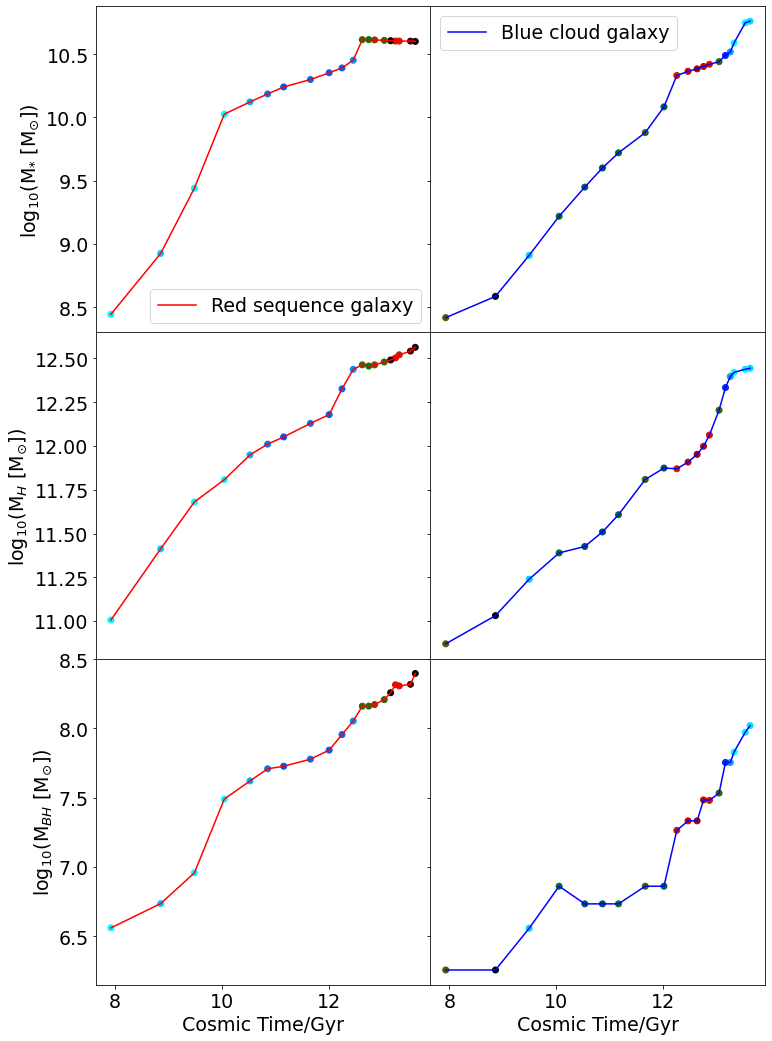

In [ ]:
cvals = [-2, -1, 0, 1, 2]
colors = ["black","red","green","blue","cyan"]
norm = plt.Normalize(min(cvals),max(cvals))
tuples = list(zip(map(norm,cvals), colors))
cmap = col.LinearSegmentedColormap.from_list("", tuples)

final = 8
r_Times = Times[0:r-final]
b_Times = Times[0:b-final]

bh_red = remove_zeros(Data_1['bh'])
bh_blue = remove_zeros(Data_2['bh'])
r2 = len(bh_red) - len(Times[0:r-final])
b2 = len(bh_blue) - len(Times[0:b-final])

fig, (ax1, ax2, ax3) = plt.subplots(3, 2, figsize = (12,18), sharex = True, sharey = 'row')

# z=0
ax1[0].plot(r_Times, log_with_zeros(Data_1['mass'])[0:-final], color = 'r', label = 'Red sequence galaxy')
ax1[1].plot(b_Times, log_with_zeros(Data_2['mass'])[0:-final], color = 'b', label = 'Blue cloud galaxy')
ax2[0].plot(r_Times, log_with_zeros(Data_1['halo'])[0:-final], color = 'r')
ax2[1].plot(b_Times, log_with_zeros(Data_2['halo'])[0:-final], color = 'b')
ax3[0].plot(r_Times, log_with_zeros(bh_red)[0:-r2], color = 'r')
ax3[1].plot(b_Times, log_with_zeros(bh_blue)[0:-b2], color = 'b')

ax1[0].scatter(r_Times, log_with_zeros(Data_1['mass'])[0:-final], c = r_diffs[0:-final], cmap = cmap)
ax1[1].scatter(b_Times, log_with_zeros(Data_2['mass'])[0:-final], c = b_diffs[0:-final], cmap = cmap)
ax2[0].scatter(r_Times, log_with_zeros(Data_1['halo'])[0:-final], c = r_diffs[0:-final], cmap = cmap)
ax2[1].scatter(b_Times, log_with_zeros(Data_2['halo'])[0:-final], c = b_diffs[0:-final], cmap = cmap)
ax3[0].scatter(r_Times, log_with_zeros(bh_red)[0:-r2], c = r_diffs[0:-final], cmap = cmap)
ax3[1].scatter(b_Times, log_with_zeros(bh_blue)[0:-b2], c = b_diffs[0:-final], cmap = cmap)

ax3[0].set_xlabel(r'Cosmic Time/Gyr')
ax3[1].set_xlabel(r'Cosmic Time/Gyr')
ax1[0].set_ylabel(r'log$_{10}$(M$_{*}$ [M$_{\odot}$])')
ax2[0].set_ylabel(r'log$_{10}$(M$_{H}$ [M$_{\odot}$])')
ax3[0].set_ylabel(r'log$_{10}$(M$_{BH}$ [M$_{\odot}$])')
plt.subplots_adjust(hspace=.0, wspace=.0)
ax1[0].legend()
ax1[1].legend()
plt.savefig('Plot_2.jpeg', bbox_inches = 'tight')
plt.show()

# Plot 3 Queries

In [ ]:
sim_name = 'RefL0100N1504'
sim_size = 100.
snapnums = [28, 19, 15, 10]
Results  = {}

for snapnum in snapnums:
    query = "SELECT \
              FOF.Group_M_Crit200 as m200, \
              SH.BlackHoleMass as bh, \
              SH.StarFormationRate as sfr, \
              SH.MassType_Star as star \
            FROM \
              %s_FOF as FOF, \
              %s_SubHalo as SH \
            WHERE \
              SH.SnapNum = %d and \
              SH.SubGroupNumber = 0 and \
              SH.MassType_Star > 0 and \
              FOF.Group_M_Crit200 > 1e10 and \
              SH.GroupID = FOF.GroupID" %(sim_name, sim_name, snapnum)
    Results[snapnum] = sql.execute_query(con, query)

In [ ]:
#Replaces zeroes with the smallest nonzero value.
def log_with_zeros(data):
  logs = np.empty(len(data))
  for i in range(0, len(data)):
    if data[i] == 0.0:
      logs[i] = 99.
    else:
      logs[i] = np.log10(data[i])
  m = logs.min()
  for j in range(0, len(logs)):
    if logs[j] == 99.:
      logs[j] = m
    else:
      logs[j] = logs[j]
  return logs

# Returns median x and y values within bins of size 'step' to make a line of "best fit"
def medians(xs, ys, min, max, step):
  xbins = np.arange(min, max+step, step)
  xmeds = np.empty(len(xbins))
  ymeds = np.empty(len(xbins))
  for i in range(len(ymeds)):
    yvals = ys[np.logical_and(xs > xbins[i], xs < (xbins[i]+step))]
    ymeds[i] = np.median(yvals)
    xvals = xs[np.logical_and(xs > xbins[i], xs < (xbins[i]+step))]
    xmeds[i] = np.median(xvals)
  return xmeds, ymeds

# Removes element from both arrays if one/both of them is zero
def remove_zeros_2(data1, data2):
  out_1 = []
  out_2 = []
  for i in range(len(data1)):
    if data1[i] == 0:
      out_1 = out_1
      out_2 = out_2
    elif data2[i] == 0:
      out_1 = out_1
      out_2 = out_2
    else:
      out_1 = out_1 + [data1[i]]
      out_2 = out_2 + [data2[i]]
  return np.array(out_1), np.array(out_2)

# Divides two arrays, but replaces #/0 with 0
def divide_with_zeros(n, d):
  res = np.empty(len(n))
  for i in range(len(n)):
    if d[i] == 0:
      res[i] = 0
    else:
      res[i] = n[i]/d[i]
  return res

# Plot 3

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


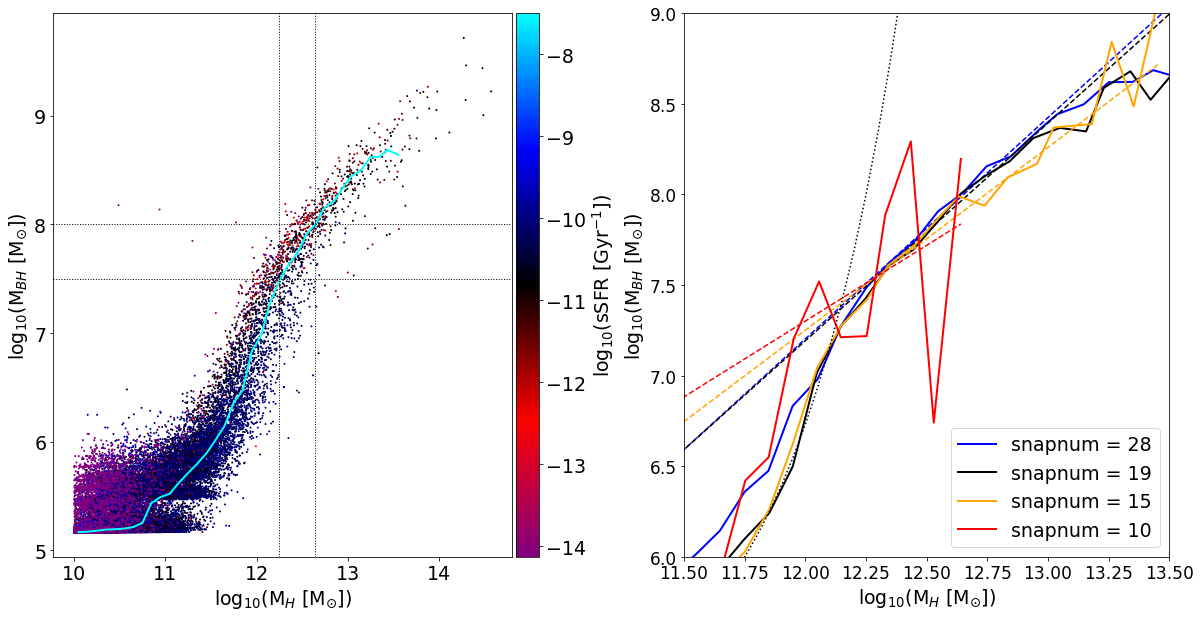

In [ ]:
colours = ['blue', 'black', 'orange', 'red']

cvals = [-2, -1 , 0, 1 , 2]
colors = ["purple","red","black","blue","cyan"]
norm = plt.Normalize(min(cvals),max(cvals))
tuples = list(zip(map(norm,cvals), colors))
cmap = col.LinearSegmentedColormap.from_list("", tuples)

sSFR1 = divide_with_zeros(Results[28]['sfr'], Results[28]['star'])
log_sSFR1 = log_with_zeros(sSFR1)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,10))

im1 = ax1.scatter(log_with_zeros(Results[28]['m200']), log_with_zeros(Results[28]['bh']), c=log_sSFR1, cmap=cmap, s=1)
meds1 = medians(log_with_zeros(Results[28]['m200']), log_with_zeros(Results[28]['bh']), 10, 13.5, 0.1)
x1 = meds1[0]
y1 = meds1[1]
ax1.plot(x1, y1, linewidth=2, color='cyan')

ax1.set_xlabel(r'log$_{10}$(M$_{H}$ [M$_{\odot}$])')
ax1.set_ylabel(r'log$_{10}$(M$_{BH}$ [M$_{\odot}$])')

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical', label = r'log$_{10}$(sSFR [Gyr$^{-1}$])')

for snapnum, colour in zip(snapnums, colours):
  meds = medians(log_with_zeros(Results[snapnum]['m200']), log_with_zeros(Results[snapnum]['bh']), 10, 13.5, 0.1)
  x = meds[0]
  y = meds[1]
  ax2.plot(x, y, linewidth=2, color=colour, label="snapnum = {0:2d}".format(snapnum))
  xl = x[np.logical_and(x > 12.25, x < 13.0)]
  yl = y[np.logical_and(x > 12.25, x < 13.0)]
  params = np.polyfit(xl, yl, 1)
  ax2.plot(x, params[0]*x + params[1], linestyle='dashed', color=colour)

xs1 = np.arange(11.5, 12.5, 0.05)
ys1 = 9**(xs1-11.75) + 5
ax2.plot(xs1, ys1, color='black', linestyle='dotted')

ax2.set_xlabel(r'log$_{10}$(M$_{H}$ [M$_{\odot}$])')
ax2.set_ylabel(r'log$_{10}$(M$_{BH}$ [M$_{\odot}$])')
ax2.set_xlim(11.5, 13.5)
ax2.set_ylim(6, 9)
ax2.tick_params(labelsize=17)
ax2.legend()

ax1.axhline(7.5, color='black', linestyle=':', linewidth=1) # 7.48831058
ax1.axvline(12.25, color='black', linestyle=':', linewidth=1) # 12.25264978
ax1.axhline(8.0, color='black', linestyle=':', linewidth=1) # 8.00860786
ax1.axvline(12.64, color='black', linestyle=':', linewidth=1) # 12.64950943

plt.subplots_adjust(wspace=0.3)
plt.savefig('Plot_3.jpeg', bbox_inches = 'tight')
plt.show()

# Plot 4 Queries

In [ ]:
def log_with_zeros(data): # Replaces zeroes with the smallest nonzero value.
  logs = np.empty(len(data))
  for i in range(0, len(data)):
    if data[i] == 0.0:
      logs[i] = 99.
    else:
      logs[i] = np.log10(data[i])
  m = logs.min()
  for j in range(0, len(logs)):
    if logs[j] == 99.:
      logs[j] = m
    else:
      logs[j] = logs[j]
  return logs

def divide_with_zeros(n, d):
  res = np.empty(len(n))
  for i in range(len(n)):
    if d[i] == 0:
      res[i] = 0
    else:
      res[i] = n[i]/d[i]
  return res

def remove_zeros(data):
  out = []
  for i in range(len(data)):
    if data[i] == 0:
      out = out
    else:
      out = out + [data[i]]
  return np.array(out)

In [ ]:
sim_name = 'RefL0100N1504'
sim_size = 100.
zs = []
halos = []
bhs = []
ssfrs = []

# For snapnums 28, 26, 23, 19, 14 ==> z = 0.0, 2.29, 5.19, 7.93, 10.86
galaxy_ids = [21573586, 21379523, 21730540, 13259036, 21109774]


for i in range(len(galaxy_ids)):
  Query = "SELECT \
              gal.Redshift as z, \
              gal.MassType_DM as halo, \
              gal.MassType_BH as bh, \
              gal.MassType_Star as star, \
              gal.StarFormationRate as sfr \
            FROM \
              %s_Subhalo as gal, \
              %s_Subhalo as ref \
            WHERE \
              ref.GalaxyID=%s and \
              ((gal.SnapNum > ref.SnapNum and ref.GalaxyID \
              between gal.GalaxyID and gal.TopLeafID) or \
              (gal.SnapNum <= ref.SnapNum and gal.GalaxyID \
              between ref.GalaxyID and ref.TopLeafID)) \
            ORDER BY \
              gal.Redshift"%(sim_name, sim_name, galaxy_ids[i])

  Data = sql.execute_query(con, Query)
  zs.append(Data['z'])
  halos.append(Data['halo'])
  bhs.append(Data['bh'])
  ssfrs.append(divide_with_zeros(Data['sfr'], Data['star']))

In [ ]:
Times = np.array([13.62, 13.53, 13.32, 13.25, 13.16, 13.04, 12.86, 12.75, 12.63, 12.46, 12.25, 12.01, 11.66, 11.16,
                  10.86, 10.53, 10.05, 9.49, 8.86, 7.93, 7.37, 6.71, 6.01, 5.19, 4.16, 3.23, 2.29, 1.24, 0.0]) # len = 29

In [ ]:
Start_times = []
P = 7.5
for i in range(len(bhs)):
  d = 29 - len(bhs[i])
  ts = Times[0:-d][np.logical_not(bhs[i] < 10**P)]
  Start_times = Start_times + [ts[-1]]
print(Start_times)

[10.86, 6.71, 10.53, 10.53, 7.93]


In [ ]:
Corrected = []

for i in range(len(Start_times)):
  c = Times - Start_times[i]
  Corrected.append(c)

# Plot 4

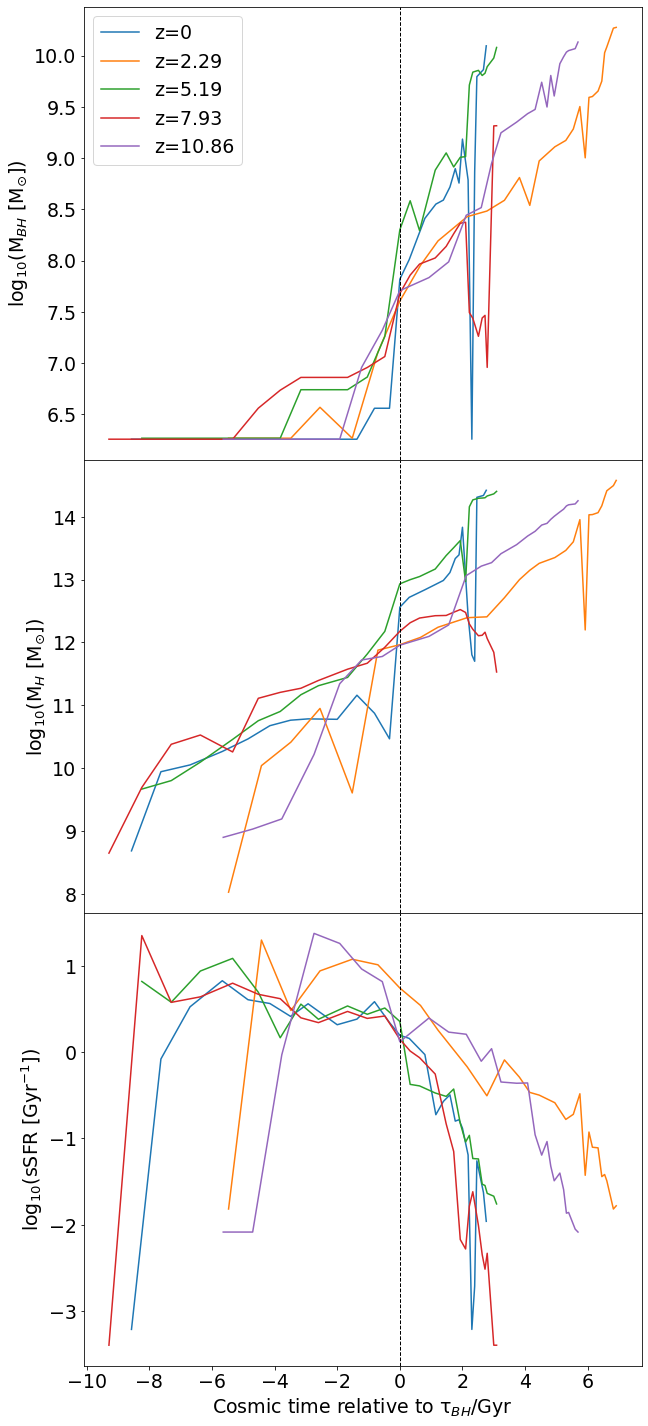

In [ ]:
redshifts = [0, 2.29, 5.19, 7.93, 10.86]

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (10,25), sharex = True)

for i in range(len(bhs)):
  d = 29 - len(bhs[i])
  ax1.plot(Corrected[i][0:-d], log_with_zeros(bhs[i]), label = 'z=%s'%(redshifts[i]))

for i in range(len(bhs)):
  d = 29 - len(bhs[i])
  ax2.plot(Corrected[i][0:-d], log_with_zeros(halos[i]), label = 'z=%s'%(redshifts[i]))

for i in range(len(bhs)):
  d = 29 - len(bhs[i])
  ax3.plot(Corrected[i][0:-d], log_with_zeros(ssfrs[i]*1e9), label = 'z=%s'%(redshifts[i]))

ax1.legend()
ax1.axvline(0, color='black', linestyle='--', linewidth=1)
ax2.axvline(0, color='black', linestyle='--', linewidth=1)
ax3.axvline(0, color='black', linestyle='--', linewidth=1)
ax3.set_xlabel('Cosmic time relative to \u03C4$_{BH}$/Gyr')
ax1.set_ylabel(r'log$_{10}$(M$_{BH}$ [M$_{\odot}$])')
ax2.set_ylabel(r'log$_{10}$(M$_{H}$ [M$_{\odot}$])')
ax3.set_ylabel(r'log$_{10}$(sSFR [Gyr$^{-1}$])')
plt.subplots_adjust(hspace=.0)

plt.savefig('Plot_4.jpeg', bbox_inches = 'tight')
plt.show()

# Mass Function Queries

In [ ]:
cosmology.setCosmology('WMAP9')
h = 0.6777
# (1E12, 0.1, mdef = 'fof', model = 'watson13')

In [ ]:
# Changes mass function from colossus units to Log10
def correct_units(input, m):
  output = (input*np.log(m))/np.log10(m)
  output = output*(h**3)
  return output

In [ ]:
powers = np.arange(10.,15.1, 0.1)
masses = 10**powers
mfunc = []

for i in range (len(masses)):
  mfunc = mfunc + [mass_function.massFunction(masses[i], 0.0, mdef = 'fof', model = 'watson13', q_out = 'dndlnM')]# mdef = 'vir', model = 'tinker08')]

mfunc = np.array(mfunc)

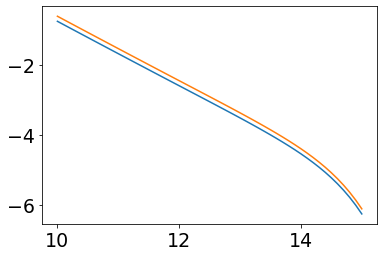

In [ ]:
plt.figure()
plt.plot(np.log10(masses),np.log10(correct_units(mfunc, masses)))
plt.plot(np.log10(masses), np.log10(mfunc))
plt.show()

In [ ]:
powers = np.arange(10.,15.1, 0.1)
masses = 10**powers

sim_name = 'RefL0100N1504'
sim_size = 100.
bin_width = 0.2
snapnums_2 = [28, 19, 15, 12, 10]
redshifts = [0.0, 1.0, 2.0, 3.0, 4.0]
Results_2 = {}
Mfuncs = {}

for num, z in zip(snapnums_2, redshifts):
  Query = "SELECT \
            %s+floor(log10(SH.MassType_DM)/%s)*%s as mass, \
            count(*) as num \
          FROM \
            %s_SubHalo as SH \
          WHERE \
            SH.SnapNum = %s and \
            SH.MassType_DM > 1e10 \
          GROUP BY \
            %s+floor(log10(SH.MassType_DM)/%s)*%s \
          ORDER BY \
            mass"%(bin_width/2, bin_width, bin_width, sim_name, num, bin_width/2, bin_width, bin_width)
  Results_2[z] = sql.execute_query(con, Query)

  mfunc = []
  for mass in masses:
    mfunc = mfunc + [mass_function.massFunction(mass, z, mdef = 'fof', model = 'watson13', q_out = 'dndlnM')]# mdef = 'vir', model = 'tinker08')]
  Mfuncs[z] = np.log10(correct_units(np.array(mfunc), masses))

# Alternative Queries

In [ ]:
sim_name = 'RefL0100N1504'
sim_size = 100.
bin_width = 0.2

Query = "SELECT \
          0.1+floor(log10(FOF.Group_M_Crit200)/%s)*%s as mass, \
          count(*) as num \
        FROM \
          %s_SubHalo as SH, \
          %s_FOF as FOF \
        WHERE \
          SH.SnapNum = 27 and \
          SH.GroupID = FOF.GroupID and \
          FOF.Group_M_Crit200 > 1e12 \
        GROUP BY \
          0.1+floor(log10(FOF.Group_M_Crit200)/%s)*%s \
        ORDER BY \
          mass"%(bin_width, bin_width, sim_name, sim_name, bin_width, bin_width)

Results = sql.execute_query(con, Query)

In [ ]:
sim_name = 'RefL0100N1504'
sim_size = 100.
bin_width = 0.2

Query = "SELECT \
          0.1+floor(log10(AP.Mass_DM)/%s)*%s as mass, \
          count(*) as num \
        FROM \
          %s_SubHalo as SH, \
          %s_Aperture as AP \
        WHERE \
          SH.GalaxyID = AP.GalaxyID and \
          AP.Mass_DM > 1e12 and \
          SH.SnapNum = 27 \
        GROUP BY \
          0.1+floor(log10(AP.Mass_DM)/%s)*%s \
        ORDER BY \
          mass"%(bin_width, bin_width, sim_name, sim_name, bin_width, bin_width)

Results = sql.execute_query(con, Query)

# Mass Function

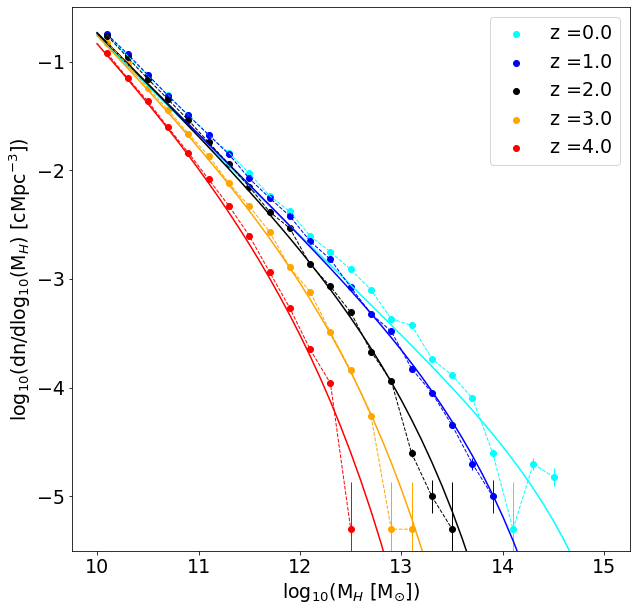

In [ ]:
plt.figure(figsize = (10,10))
colours = ['cyan', 'blue', 'black', 'orange', 'red']

for z, colour in zip(redshifts, colours):
  hist = Results_2[z]['num'][:] / float(sim_size)**3.
  hist = hist / bin_width

  errors = []
  for i in range(len(Results_2[z]['num'])):
    error = math.sqrt(1/Results_2[z]['num'][i])/(bin_width*sim_size**3)
    log_error = (1/np.log(10)) * (error/hist[i])
    errors = errors + [log_error]
  errors = np.array(errors)

  plt.errorbar(Results_2[z]['mass'], np.log10(hist), yerr=errors,
               color=colour, linestyle='--', linewidth=1)
  plt.scatter(Results_2[z]['mass'], np.log10(hist), label="z ={0:2s}".format(str(z)), color=colour)
  plt.plot(np.log10(masses), Mfuncs[z], color=colour)

plt.xlabel(r'log$_{10}$(M$_{H}$ [M$_{\odot}$])')
plt.ylabel(r'log$_{10}$(dn/dlog$_{10}$(M$_{H}$) [cMpc$^{-3}$])')
plt.legend()
plt.ylim(-5.5, -0.5)

plt.savefig('Mass_Function.jpeg', bbox_inches = 'tight')
plt.show()

# Mass Function 2 Queries

In [ ]:
cosmology.setCosmology('WMAP9')
h = 0.6777
# (1E12, 0.1, mdef = 'fof', model = 'watson13')

In [ ]:
# Changes mass function from colossus units to Log10
def correct_units(input, m):
  output = (input*np.log(m))/np.log10(m)
  output = output*(h**3)
  return output

In [ ]:
bin_width = 0.25
powers = np.arange(12.,15.0 + bin_width, bin_width)
masses = 10**powers
redshifts_2 = [0.0,0.1,0.18,0.27,0.37,0.5,0.62,0.74,0.87,
               1.0,1.26,1.49,1.74,2.0,2.24,2.48,3.0,3.53,4.0]
Results_3 = {}

for z in redshifts_2:
  mfunc = []
  for mass in masses:
    mfunc = mfunc + [mass_function.massFunction(mass, z, mdef = 'fof', model = 'watson13', q_out = 'dndlnM')]# mdef = 'vir', model = 'tinker08')]
  Results_3[z] = np.log10(np.array(mfunc)*(h**3)) # np.log10(correct_units(np.array(mfunc), masses))

In [ ]:
Results_4 = {}

for mass in powers:
    Results_4[mass] = []

for z in redshifts_2:
  hist = Results_3[z]
  for i in range(len(powers)):
    mass = powers[i]
    Results_4[mass] = Results_4[mass] + [hist[i]]

# Mass Function 2

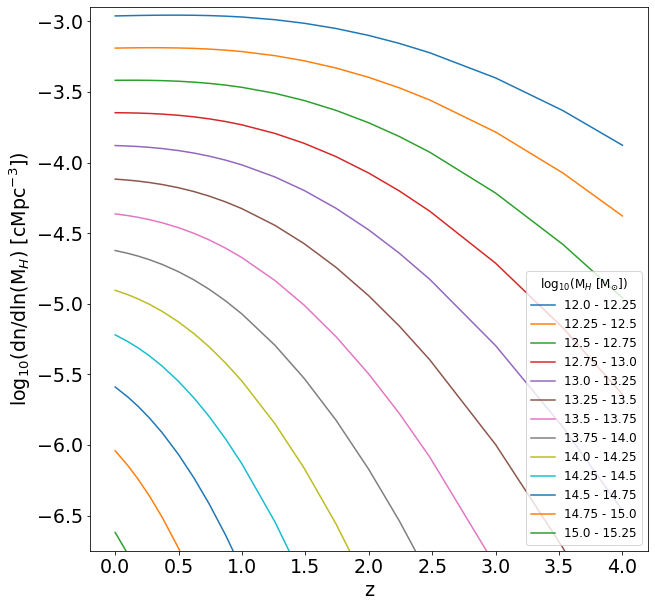

In [ ]:
plt.figure(figsize = (10,10))

for mass in powers:
  Results_4[mass] = np.array(Results_4[mass])
  plt.plot(redshifts_2, Results_4[mass],
             label="%s - %s"%(math.ceil((mass)*100)/100, math.ceil((mass+bin_width)*100)/100))

plt.xlabel(r'z')
plt.ylabel(r'log$_{10}$(dn/dln(M$_{H}$) [cMpc$^{-3}$])')
plt.rcParams['font.size'] = '12'
plt.legend(title=r'log$_{10}$(M$_{H}$ [M$_{\odot}$])', loc='lower right')
plt.rcParams['font.size'] = '19'
plt.ylim(-6.75, -2.9)
         
plt.savefig('Mass_Function_2.jpeg', bbox_inches = 'tight')
plt.show()

# Plot 5 Queries

In [ ]:
sim_name = 'RefL0100N1504' # SnapNum 100 ==> z=2
sim_size = 100.

Query_IDs = "SELECT \
            log10(SH.MassType_DM) as halo, \
            SH.Redshift as z, \
            SH.GalaxyID as id \
           FROM \
            %s_SubHalo as SH \
           WHERE \
            SH.SnapNum = 15 and \
            SH.SubGroupNumber = 0 and \
            SH.MassType_DM between 1.0e12 and 1.25e12"%(sim_name)

Data_IDs = sql.execute_query(con, Query_IDs)
print(len(Data_IDs['id']))
print(Data_IDs['z'][0])

130
2.0124102


In [ ]:
sim_name = 'RefL0100N1504'
sim_size = 100.
max = 19
min = 10
IDs = Data_IDs['id']
nums = np.arange(len(IDs)) + 1
Results_5 = {}

for ID, num in zip(IDs, nums):
  Query = "SELECT \
            gal.Redshift as z, \
            gal.MassType_DM as halo \
          FROM \
            %s_Subhalo as gal, \
            %s_Subhalo as ref \
          WHERE \
            ref.GalaxyID=%s and \
            ((gal.SnapNum between ref.SnapNum and %s and ref.GalaxyID \
            between gal.GalaxyID and gal.TopLeafID) or \
            (gal.SnapNum between %s and ref.SnapNum and gal.GalaxyID \
            between ref.GalaxyID and ref.TopLeafID) or \
            (gal.SnapNum between 27 and 28 and ref.GalaxyID \
            between gal.GalaxyID and gal.TopLeafID)) \
          ORDER BY \
            gal.Redshift"%(sim_name, sim_name, ID, max, min)
  Results_5[num] = sql.execute_query(con, Query)

In [ ]:
# Replaces zeroes with the smallest nonzero value.
def ln_with_zeros(data):
  logs = np.empty(len(data))
  for i in range(0, len(data)):
    if data[i] == 0.0:
      logs[i] = 99.
    else:
      logs[i] = np.log(data[i])
  m = logs.min()
  for j in range(0, len(logs)):
    if logs[j] == 99.:
      logs[j] = m
    else:
      logs[j] = logs[j]
  return logs

# Replaces zeroes with the smallest nonzero value.
def log_with_zeros(data):
  logs = np.empty(len(data))
  for i in range(0, len(data)):
    if data[i] == 0.0:
      logs[i] = 99.
    else:
      logs[i] = np.log10(data[i])
  m = logs.min()
  for j in range(0, len(logs)):
    if logs[j] == 99.:
      logs[j] = m
    else:
      logs[j] = logs[j]
  return logs

# Returns median y values within bins of size 'step' to make a line of "best fit"
def medians(xs, ys, min, max, step):
  xvals = np.arange(min, max+step, step)
  meds = np.empty(len(xvals))
  for i in range(len(meds)):
    yvals = ys[np.logical_and(xs > xvals[i], xs < (xvals[i]+step))]
    meds[i] = np.median(yvals)
    print(meds)
  return xvals + step/2, meds

# Plot 5

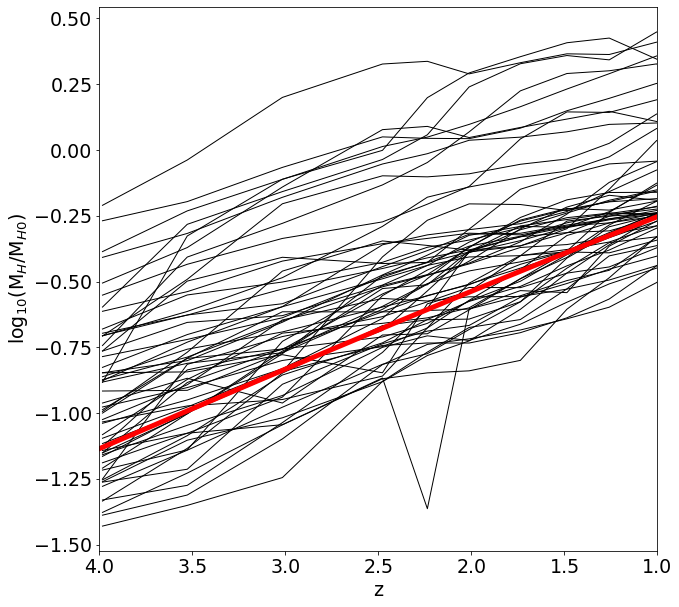

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,10))

# Plot 1
all_Rs = []
all_zs = []
for num in nums:
  M = Results_5[num]['halo']
  z = Results_5[num]['z']
  M = Results_5[num]['halo'][z <= 15]
  z = Results_5[num]['z'][z <= 15]
  if z[0] < 0.5:
    if M[0] > 0:
      R = log_with_zeros(M/M[0])
    else:
      R = log_with_zeros(M/M[1])
    if R.max() < 0.5 and R.min() > -1.5:
      ax1.plot(z, R, linewidth=1, color='black')
      all_Rs = all_Rs + list(R)
      all_zs = all_zs + list(z)

all_Rs = np.array(all_Rs)
all_zs = np.array(all_zs)
#Meds = medians(all_zs, all_Rs, 1.0, 4.0, 1.0)
#ax1.plot(Meds[0], Meds[1], color='b', linewidth=5)

zs = np.arange(4, 1, -0.01)
z2 = zs # - 1.0
a = 0.24
b = 0.75
ax1.plot(zs, np.log10((1+z2)**a*np.exp(-b*z2)), '-', linewidth=5, color='red')


ax1.set_xlabel(r'z')
ax1.set_ylabel(r'log$_{10}$(M$_{H}$/M$_{H0}$)')
ax1.set_xlim(4.0,1.0)
plt.savefig('Plot_5.jpeg', bbox_inches = 'tight')
plt.show()

# Plot 5 Queries (Old)

In [ ]:
sim_name = 'RefL0100N1504'
sim_size = 100.
snapnums_3 = np.arange(10,29)[::-1]
redshifts_2 = [0.0,0.1,0.18,0.27,0.37,0.5,0.62,0.74,0.87,
               1.0,1.26,1.49,1.74,2.0,2.24,2.48,3.0,3.53,4.0]
Results_5 = {}

for snapnum in snapnums_3:
  Query = "SELECT \
            log10(SH.MassType_DM) as halo \
           FROM \
            %s_SubHalo as SH \
           WHERE \
            SH.SnapNum = %s and \
            SH.SubGroupNumber = 0 and \
            SH.MassType_DM > 1.0e12"%(sim_name, snapnum)
  Results_5[snapnum] = sql.execute_query(con, Query)

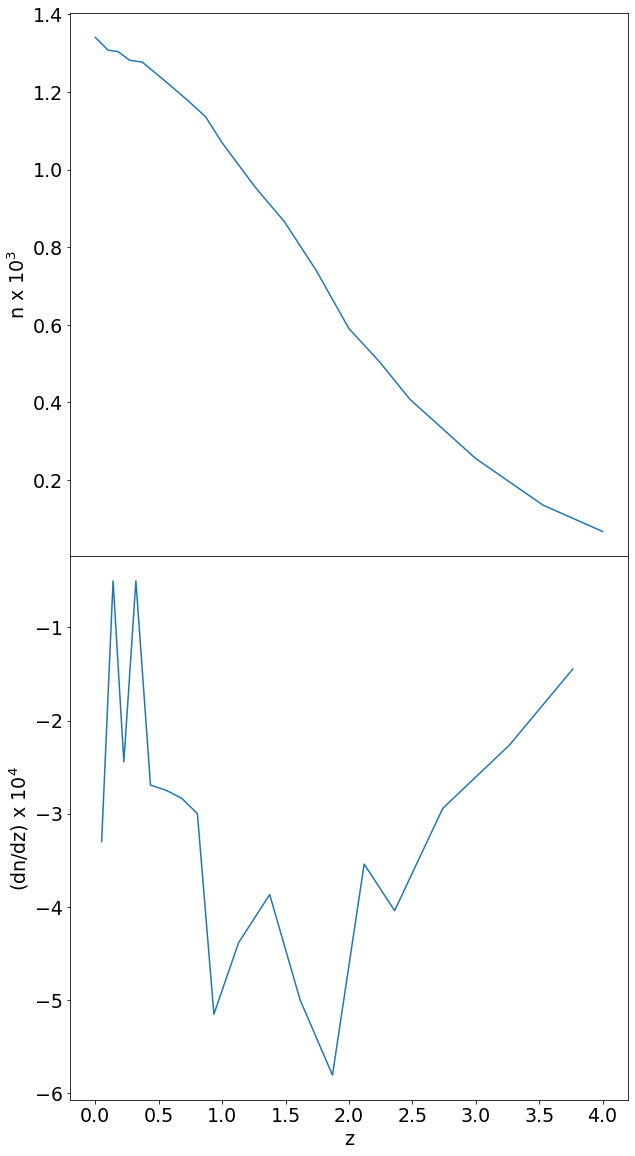

In [ ]:
Counts = []

for snapnum in snapnums_3:
  Counts = Counts + [len(Results_5[snapnum]['halo'])]
Counts = np.array(Counts)/(sim_size**3)

Grads = []
zs = []

for i in range(len(Counts)-1):
  dn = Counts[i+1]-Counts[i]
  dz = redshifts_2[i+1]-redshifts_2[i]
  grad = dn/dz
  Grads = Grads + [grad]
  zs = zs + [redshifts_2[i] + dz/2]
Grads = np.array(Grads)

fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, figsize=(10,20))

ax1.plot(redshifts_2, Counts * 1e3)
ax2.plot(zs, Grads * 1e4)

ax1.set_xlabel('z')
ax1.set_ylabel('n x 10$^{3}$')
ax2.set_xlabel('z')
ax2.set_ylabel('(dn/dz) x 10$^{4}$')
plt.subplots_adjust(hspace=0)
plt.show()

# Plot 6

In [ ]:
cosmology.setCosmology('WMAP9')
h = 0.6777
# (1E12, 0.1, mdef = 'fof', model = 'watson13')

In [ ]:
# mass_function.massFunction(mass, z, mdef = 'fof', model = 'watson13', q_out = 'dndlnM')
Mfuncs = []

redshifts_3 = np.arange(4.0, -0.01, -0.01)

for z in redshifts_3:
  mfunc = mass_function.massFunction(1e12, z, mdef = 'fof',
                                     model = 'watson13', q_out = 'dndlnM')
  Mfuncs = Mfuncs + [mfunc]

Mfuncs = np.array(Mfuncs)*(h**3)

In [ ]:
# Query to determine the rate of formation of halos of a given mass
# snipshot query
sim_name = 'Snipshots..RefL0100N1504'
m_select = 1e12 # mass above which we select halos
# merger tree query
Results   = {}
step = 5
snapnums  = np.arange(50, 200 + step, step)
for snapnum in snapnums:
  myQuery = "SELECT \
                  PROG.GalaxyID as galaxyid, \
                  PROG.TopLeafID as topleafid, \
                  DES.GalaxyID as descid, \
                  PROG.Redshift as zprog, \
                  DES.Redshift as zdesc,\
                  PROG.MassType_DM as Mprog, \
                  DES.MassType_DM as Mdesc, \
                  PROG.SnapNum as snapnum \
          FROM \
                  {0:s}_Subhalo as PROG, \
                  {1:s}_Subhalo as DES \
          WHERE \
                  DES.MassType_DM > {2:2.2e} \
                  and PROG.MassType_DM < {2:2.2e} \
                  and DES.SnapNum = {3:2d} \
                  and PROG.SnapNum = {4:2d} \
                  and PROG.GalaxyID between DES.GalaxyID and DES.TopLeafID \
          ORDER BY \
                  PROG.Redshift asc".format(sim_name, sim_name, m_select, snapnum, snapnum-1)
  Results[snapnum] = {}
  Results[snapnum]["data"]  = sql.execute_query(con, myQuery)
  Results[snapnum]['nform'] = len(Results[snapnum]["data"]['descid'])
  Results[snapnum]['zform'] = Results[snapnum]["data"]['zdesc'][0]


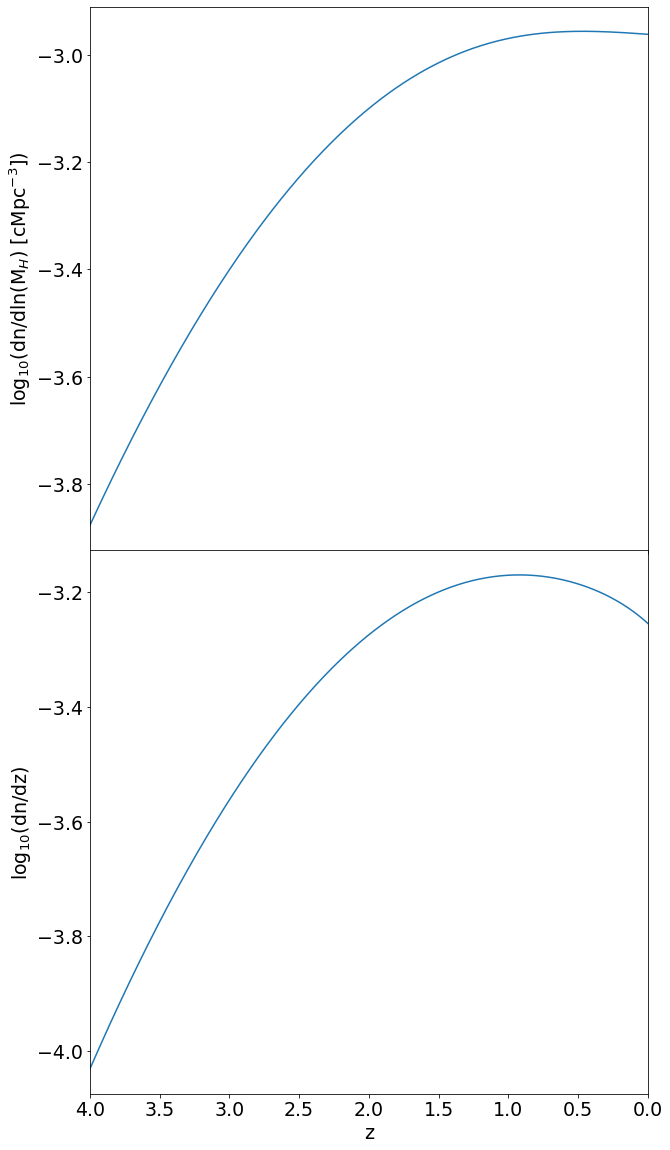

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,20), sharex=True)

ax1.plot(redshifts_3, np.log10(Mfuncs))

a = 0.24
b = 0.75
log_growth_rate = (a/(1 + redshifts_3)) - b
formation_rate = abs(Mfuncs * log_growth_rate)

ax2.plot(redshifts_3, np.log10(formation_rate))

'''
zs     = []
nforms = []
simvol = 100**3
for snapnum in snapnums:
  zs.append(Results[snapnum]['zform'])
  nforms.append(Results[snapnum]['nform'])

zs      = np.array(zs)
nforms  = np.array(nforms)
dzs     = zs[0:-1] - zs[1:]
zcs     = 0.5*(zs[0:-1] + zs[1:])
dns     = nforms[1:] / dzs / simvol # how is this dn?

#ax2.plot(zcs, np.log10(dns), 'D', color='red')
'''

plt.xlim(4.0, 0.0)
ax1.set_ylabel(r'log$_{10}$(dn/dln(M$_{H}$) [cMpc$^{-3}$])')
ax2.set_xlabel(r'z')
ax2.set_ylabel(r'log$_{10}$(dn/dz)')
plt.subplots_adjust(hspace=0)
plt.savefig('Plot_6L.jpeg', bbox_inches = 'tight')
plt.show()

# New section

In [ ]:
# Query to determine the rate of formation of halos of a given mass
# snipshot query
sim_name = 'Snipshots..RefL0100N1504'
m_select = 1e12 # mass above which we select halos
# merger tree query
Results   = {}
step = 5
snapnums  = np.arange(50, 200 + step, step)
for snapnum in snapnums:
  myQuery = "SELECT \
                  PROG.GalaxyID as galaxyid, \
                  PROG.TopLeafID as topleafid, \
                  DES.GalaxyID as descid, \
                  PROG.Redshift as zprog, \
                  DES.Redshift as zdesc,\
                  PROG.MassType_DM as Mprog, \
                  DES.MassType_DM as Mdesc, \
                  PROG.SnapNum as snapnum \
          FROM \
                  {0:s}_Subhalo as PROG, \
                  {1:s}_Subhalo as DES \
          WHERE \
                  DES.MassType_DM > {2:2.2e} \
                  and PROG.MassType_DM < {2:2.2e} \
                  and DES.SnapNum = {3:2d} \
                  and PROG.SnapNum = {4:2d} \
                  and PROG.GalaxyID between DES.GalaxyID and DES.TopLeafID \
          ORDER BY \
                  PROG.Redshift asc".format(sim_name, sim_name, m_select, snapnum, snapnum-1)
  Results[snapnum] = {}
  Results[snapnum]["data"]  = sql.execute_query(con, myQuery)
  Results[snapnum]['nform'] = len(Results[snapnum]["data"]['descid'])
  Results[snapnum]['zform'] = Results[snapnum]["data"]['zdesc'][0]


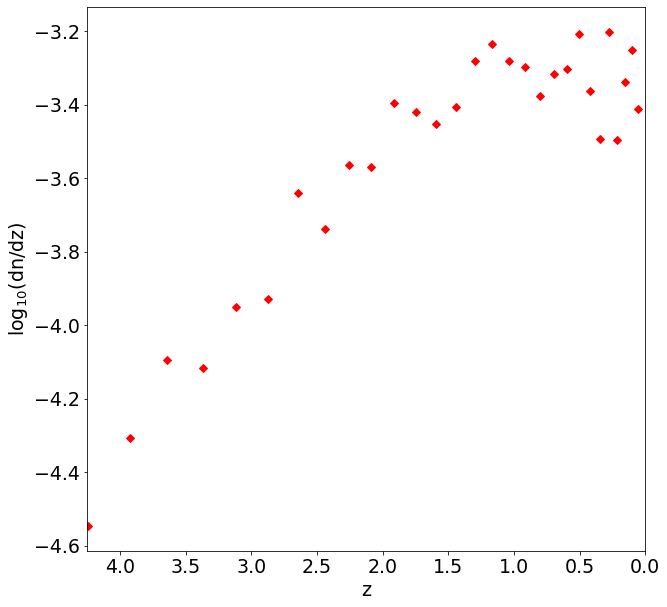

In [ ]:
zs     = []
nforms = []
simvol = 100**3
for snapnum in snapnums:
  zs.append(Results[snapnum]['zform'])
  nforms.append(Results[snapnum]['nform'])

zs      = np.array(zs)
nforms  = np.array(nforms)
dzs     = zs[0:-1] - zs[1:]
zcs     = 0.5*(zs[0:-1] + zs[1:])
dns     = nforms[1:] / dzs / simvol # how is this dn?
fig, ax = plt.subplots(1,1, figsize=(10, 10))
ax.plot(zcs, np.log10(dns), 'D', color='red')
ax.set_xlabel(r'z')
ax.set_ylabel(r'log$_{10}$(dn/dz)')
ax.set_xlim(4.25, 0)
fig.show()

In [ ]:

for snapnum in snapnums:
  data = Results[snapnum]['data']
  # extract the descendents
  galaxyids  = data['descid']
  topleafids = data['topleafid']
  progids    = data['galaxyid']
  print(snapnum, len(galaxyids))
  for galaxyid, topleafid in zip(galaxyids, topleafids):
    # select the progenitors for this galaxy
    mask = (progids >= galaxyid) & (progids <= topleafid)
    # print(galaxyid, np.sum(mask))


50 12
55 10
60 14
65 23
70 20
75 27
80 29
85 48
90 36
95 46
100 48
105 68
110 61
115 54
120 57
125 72
130 76
135 65
140 59
145 46
150 49
155 51
160 53
165 34
170 23
175 41
180 19
185 25
190 28
195 16
